### **Overview**

 **NLP INTENT CLASSIFIER**
 
 Goal:
   Predict caller intent (topics) from call text so we can:
       - detect why people are calling
       - route complex calls
       - build future automation

 Inputs:
   - topics_detected (list-like text column)
   - customer_feedback_text
   - agent_notes

 Outputs:
   - Trained classifier
   - Saved TF-IDF vectorizer + model for Streamlit

 Notes:
   - Designed to be robust with small datasets (~200 rows)
   - Fully defensively coded against NaNs + malformed data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv(r"C:\Users\pc\Desktop\Pro_Jets\CC EDA&ML\EDA notebook\df_copy.csv")
df.head()

,interaction_id,customer_id,agent_id,interaction_datetime,interaction_duration_seconds,call_direction,call_channel,call_status,customer_satisfaction_score,speech_sentiment_score,...,issue_resolved,follow_up_required,follow_up_due_date,language,customer_feedback_text,agent_notes,call_hour,call_dayofweek,csat_band,hour
0,INT00001,CUST00001,AGT0001,2024-01-01 09:10:13,415,inbound,phone,completed,4.7,0.82,...,True,False,NaN,en,"Thank you for your help, great service.",Customer called regarding password reset. Issu...,9,Monday,4-5,9
1,INT00002,CUST00002,AGT0002,2024-01-01 11:24:50,23,outbound,phone,dropped,NaN,NaN,...,False,False,NaN,en,NaN,Call dropped instantly. No customer response.,11,Monday,NaN,11
2,INT00003,CUST00003,AGT0003,2024-01-01 13:32:05,198,inbound,chat,completed,4.1,0.63,...,True,False,NaN,es,"Gracias, todo bien.",Customer requested recent statements. Provided...,13,Monday,4-5,13
3,INT00004,CUST00001,AGT0004,2024-01-02 10:45:14,37,inbound,phone,abandoned,0.0,-0.95,...,False,False,NaN,en,NaN,Caller disconnected before an agent could answer.,10,Tuesday,NaN,10
4,INT00005,CUST00004,AGT0001,2024-01-02 15:08:55,720,inbound,phone,completed,4.5,0.91,...,True,False,NaN,en,Resolved my issue quickly.,Customer reported card decline online. Walked ...,15,Tuesday,4-5,15


#### **Block 1 - Extract Primary Intent From Topics Detected**

In [3]:
# SAFELY PARSE topics_detected
# Purpose: Convert string lists → real Python lists
# Example:
# "[password_reset, billing]" → ["password_reset","billing"]

def safe_parse_topics(x):
    if pd.isna(x):
        return []
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["topics_detected"] = df["topics_detected"].apply(safe_parse_topics)

In [4]:
# Extract primary intent label from topics_detected

def extract_primary_topic(x):
    # Handle missing
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return "unknown"
    
    # If already list → use it
    if isinstance(x, list):
        return x[0] if len(x) else "unknown"
    
    # If numpy array → convert to list
    if isinstance(x, np.ndarray):
        x = x.tolist()
        return x[0] if len(x) else "unknown"
    
    # If string → try parse
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list) and len(parsed):
                return parsed[0]
            return "unknown"
        except:
            return "unknown"
    
    # Fallback
    return "unknown"

df["intent_label"] = df["topics_detected"].apply(extract_primary_topic)

In [5]:
df["topics_detected"].apply(type).value_counts()

topics_detected
<class 'list'>    200
Name: count, dtype: int64

In [6]:
df["topics_detected"].head(10)

0        [password_reset, online_banking]
1                                      []
2    [statement_request, balance_inquiry]
3                                      []
4            [card_issue, online_payment]
5    [customer_outreach, account_upgrade]
6                                      []
7           [complaint, fees, escalation]
8        [profile_update, account_access]
9                                      []
Name: topics_detected, dtype: object

In [7]:
df["intent_label"].head(10)

0       password_reset
1              unknown
2    statement_request
3              unknown
4           card_issue
5    customer_outreach
6              unknown
7            complaint
8       profile_update
9              unknown
Name: intent_label, dtype: object

#### Unkowns are valid data, but we don't want it interfering with out build so we'll have to restrict it in block 3.

#### **Block 2 - Build Text Field for Training**

In [8]:
# BUILD CLEAN TEXT FIELD
# Combine:
#   - customer text
#   - agent notes
#
# Replace missing values → ""

df["customer_feedback_text"] = df["customer_feedback_text"].fillna("")
df["agent_notes"] = df["agent_notes"].fillna("")

df["text_all"] = (
    df["customer_feedback_text"].astype(str)
    + " "
    + df["agent_notes"].astype(str)
)

In [9]:
# SIMPLE TEXT CLEANER (optional but useful)

def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_all"] = df["text_all"].apply(clean_text)

#### **Block 3 -  Prep Data for Training** (Also cleaning the unkowns as promised ealier)

In [10]:
# DROP EMPTY TEXT ROWS

df = df[df["text_all"].str.len() > 0].copy()

# Keep only rows with known intents
df_train = df[df["intent_label"] != "unknown"].copy()

print("Training rows:", len(df_train))
print("Unknown removed:", df.shape[0] - df_train.shape[0])

# ENCODE TARGET LABELS

label_encoder = LabelEncoder()
df_train["intent_encoded"] = label_encoder.fit_transform(df_train["intent_label"])

Training rows: 135
Unknown removed: 65


In [11]:
label_counts = df_train["intent_label"].value_counts().sort_values(ascending=True)
label_counts

intent_label
direct_deposit             1
account_access             1
enrollment                 1
transactions               1
deposit_inquiry            1
pin_change                 1
statement_inquiry          1
exchange_rate              1
fund_transfer              1
mortgage_status            1
loan_balance               1
card_services              1
pin_reset                  1
travel_notification        1
charges_inquiry            1
checkbook_request          1
atm                        1
rewards                    1
loan_statement             1
fraud_report               1
international_transfer     1
review                     1
mortgage_update            1
bill_pay                   1
account_info               1
app_support                1
address_change             1
application_status         1
fraud                      1
account_management         1
alerts                     1
travel_notice              1
mobile_banking             2
account_update             2
a

In [12]:
# Ran into some issue with exsiting mapping so I had to make a better one
merge_map = {

    # --- Security / Auth ---
    "pin_change": "security_issue",
    "pin_reset": "security_issue",

    # --- Fraud ---
    "fraud_report": "fraud",
    "fraud": "fraud",

    # --- Disputes ---
    "transaction_dispute": "dispute",
    "charges_inquiry": "dispute",

    # --- Payments / Transfers ---
    "fund_transfer": "payment_issue",
    "international_transfer": "payment_issue",
    "bill_pay": "payment_issue",
    "auto_payment": "payment_issue",
    "loan_payment": "payment_issue",
    "direct_deposit": "payment_issue",

    # --- Loans & Mortgage ---
    "loan_inquiry": "loan_inquiry",
    "loan_balance": "loan_inquiry",
    "loan_status": "loan_inquiry",
    "loan_statement": "loan_inquiry",
    "mortgage": "loan_inquiry",
    "mortgage_status": "loan_inquiry",
    "mortgage_update": "loan_inquiry",

    # --- Cards ---
    "card_services": "card_issue",
    "card_activation": "card_issue",
    "card_issue": "card_issue",
    "travel_notice": "card_issue",
    "travel_notification": "card_issue",

    # --- Account Changes ---
    "account_update": "profile_update",
    "account_management": "profile_update",
    "address_change": "profile_update",
    "account_access": "profile_update",
    "account_info": "profile_update",
    "profile_update": "profile_update",
    "account_opening": "account_opening",

    # --- Closure ---
    "account_closure": "account_closure",

    # --- General Banking ---
    "balance_inquiry": "balance_inquiry",
    "statement_inquiry": "statement_request",
    "statement_request": "statement_request",
    "transactions": "transaction_history",
    "transaction_history": "transaction_history",

    # --- Tech Support ---
    "app_support": "technical_issue",
    "online_banking": "technical_issue",
    "mobile_banking": "technical_issue",

    # --- Investment ---
    "investment": "investment_inquiry",
    "investment_inquiry": "investment_inquiry",

    # --- Rewards / ATM / Checkbook ---
    "rewards": "account_service",
    "atm": "account_service",
    "checkbook_request": "account_service",

    # --- Review / Feedback ---
    "review": "customer_outreach",
    "alerts": "customer_outreach",

    # --- Escalations ---
    "escalation": "escalation",
    
    # --- Unknown stays ---
    "unknown": "unknown"
}

In [13]:
# Appying the merge
label_counts = df_train["intent_label"].value_counts()
rare_labels = label_counts[label_counts < 15].index.tolist()

def normalize_label(label):
    if label in merge_map:
        return merge_map[label]
    elif label in rare_labels:
        return "other"
    return label

df_train["intent_label_clean"] = df_train["intent_label"].apply(normalize_label)

In [14]:
df_train["intent_label_clean"].value_counts()

intent_label_clean
customer_outreach      25
other                  24
profile_update         18
loan_inquiry           10
statement_request       8
card_issue              8
payment_issue           8
balance_inquiry         5
technical_issue         5
investment_inquiry      4
account_service         3
account_closure         3
dispute                 3
transaction_history     3
security_issue          2
account_opening         2
fraud                   2
escalation              2
Name: count, dtype: int64

#### **Block 5 - Train only on meaningful labels**

In [15]:
# Excluding unwanted features 
df_train = df_train[
    ~df_train["intent_label_clean"].isin(["unknown", "other"])
].copy()

In [16]:
label_encoder = LabelEncoder()
df_train["intent_encoded"] = label_encoder.fit_transform(df_train["intent_label_clean"])

In [17]:
# TRAIN / TEST SPLIT

X = df_train["text_all"]
y = df_train["intent_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [18]:
# BUILD MODEL PIPELINE

# Model choice:
#   Logistic Regression
# Why?
#   - Works great for small datasets
#   - Fast
#   - Stable + interpretable
#   - Production-ready

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=5000,
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=200))
])

# TRAIN MODEL
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=200))])

In [19]:
# ===== PREDICT =====
y_pred = pipeline.predict(X_test)

**Note:** Always pass labels explicitly based on the encoder outputs used during training - but filtered to match the encoded y values.

In [20]:
# Get the sorted unique encoded class ids present in y_test or model
present_labels = np.unique(np.concatenate([y_test, y_pred]))
present_labels = np.sort(present_labels)

# Map them back to names
present_names = label_encoder.inverse_transform(present_labels)

In [21]:
# EVALUATE PERFORMANCE



print("===== CLASSIFICATION REPORT =====")
print(
    classification_report(
        y_test, 
        y_pred, 
        labels=present_labels,
        target_names=present_names,
        zero_division=0
    )
)

===== CLASSIFICATION REPORT =====
                     precision    recall  f1-score   support

    account_closure       0.00      0.00      0.00         1
    account_service       0.00      0.00      0.00         1
    balance_inquiry       0.00      0.00      0.00         1
         card_issue       1.00      0.50      0.67         2
  customer_outreach       0.35      1.00      0.52         6
            dispute       0.00      0.00      0.00         1
              fraud       0.00      0.00      0.00         1
 investment_inquiry       0.00      0.00      0.00         1
       loan_inquiry       1.00      0.33      0.50         3
      payment_issue       1.00      0.50      0.67         2
     profile_update       0.50      0.80      0.62         5
  statement_request       0.00      0.00      0.00         2
    technical_issue       0.00      0.00      0.00         1
transaction_history       0.00      0.00      0.00         1

           accuracy                           0.4

**Multi-class classification**

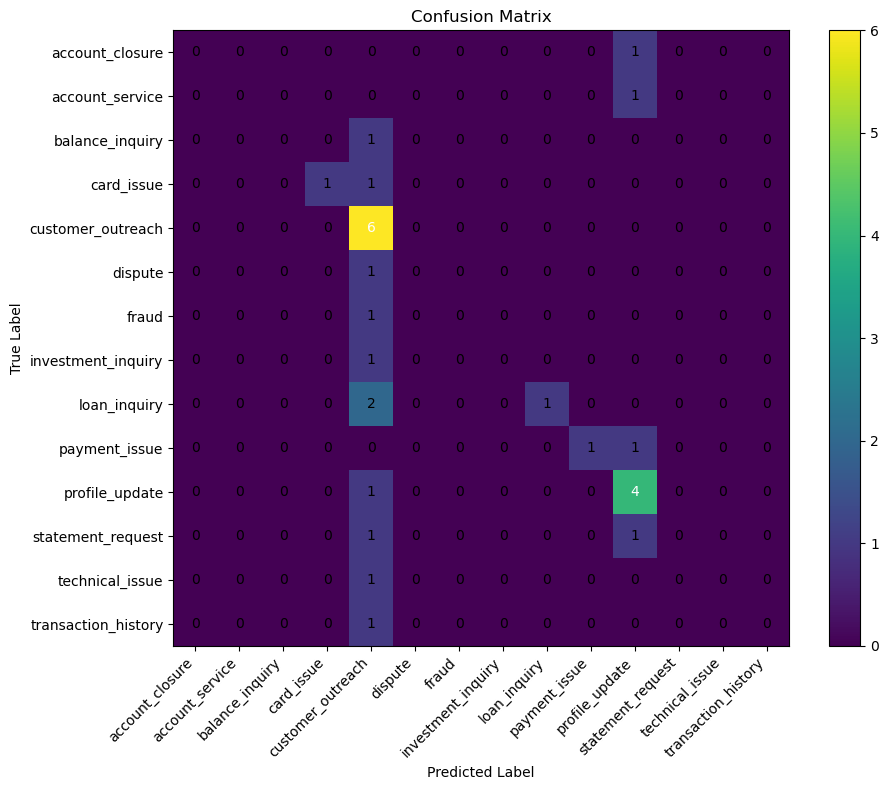

In [29]:

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=present_labels)

# Map encoded ids back to names
class_names = label_encoder.inverse_transform(present_labels)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Show counts inside squares
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

**Take away**
Even though accuracy ≈ 46%:
The model is very confident when it has enough examples
The poor scores on many labels are purely due to tiny support (1–2 samples)

So yes — in this situation:
Quality + balanced representation beat raw quantity

10–20 good examples per label can outperform 200 messy ones.

In [22]:
# Logging the class mapping
for i, name in enumerate(label_encoder.classes_):
    print(i, "→", name)

0 → account_closure
1 → account_opening
2 → account_service
3 → balance_inquiry
4 → card_issue
5 → customer_outreach
6 → dispute
7 → escalation
8 → fraud
9 → investment_inquiry
10 → loan_inquiry
11 → payment_issue
12 → profile_update
13 → security_issue
14 → statement_request
15 → technical_issue
16 → transaction_history


#### **Block 4 - Saving...**

In [23]:
# SAVE ARTIFACTS FOR STREAMLIT

joblib.dump(pipeline, "intent_classifier.pkl")
joblib.dump(label_encoder, "intent_label_encoder.pkl")

print("Models saved successfully.")

Models saved successfully.


In [43]:
# INFERENCE EXAMPLE

def predict_intent(text):
    text = clean_text(text)
    pred_class = pipeline.predict([text])[0]
    return label_encoder.inverse_transform([pred_class])[0]

print(
    predict_intent(
        "shihihiihhiihihih"
    )
)


customer_outreach


In [44]:
# --- CONFIDENCE SCORING FUNCTION ---
import numpy as np

def predict_with_confidence(text, pipeline, label_encoder):
    """
    Returns:
      predicted_label, confidence_score, probability_vector
    """
    probs = pipeline.predict_proba([text])[0]
    pred_idx = np.argmax(probs)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = probs[pred_idx]

    return pred_label, float(confidence), probs


In [54]:
text = "I want to update my phone number on my account"

label, conf, probs = predict_with_confidence(text, pipeline, label_encoder)

print(label, conf)


profile_update 0.21742893312163922


In [55]:
# Create an explainer

In [56]:
# --- KEYWORD EXPLANATION FUNCTION ---

def explain_prediction(text, pipeline, label_encoder, top_k=8):
    
    tfidf = pipeline.named_steps["tfidf"]
    clf = pipeline.named_steps["clf"]

    # Transform text → tfidf vector
    vec = tfidf.transform([text])

    # Predict class
    probs = clf.predict_proba(vec)[0]
    pred_idx = np.argmax(probs)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]

    # Pull weights for that class
    class_coef = clf.coef_[pred_idx]

    # Multiply word tf-idf contribution × class weight
    word_contrib = vec.toarray()[0] * class_coef

    # Get top contributing tokens
    top_indices = np.argsort(word_contrib)[::-1][:top_k]

    keywords = []
    feature_names = tfidf.get_feature_names_out()

    for idx in top_indices:
        if vec.toarray()[0][idx] > 0:
            keywords.append((feature_names[idx], float(word_contrib[idx])))

    return pred_label, float(probs[pred_idx]), keywords


In [57]:
text = "My card stopped working and I need a replacement"

label, conf, kw = explain_prediction(text, pipeline, label_encoder)

print("INTENT:", label)
print("CONFIDENCE:", round(conf,3))
print("KEYWORDS:", kw)


INTENT: customer_outreach
CONFIDENCE: 0.18
KEYWORDS: [('card', 0.003612829686922397)]


**If you want to improve confidence level you can try this**

Merge classes with ~1–2 examples → group into broader intents
(e.g., loan_inquiry, loan_status → loan_related)
for this demo i'm okay with this.